In [1]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
import seaborn as sns
sns.set(context='poster', style='white')

In [3]:
def get_W_witness_spectrum(P, Q):
    n = len(P)
    X = np.concatenate([P, Q], axis=0)
    c = np.array(n*[-1/n] + n*[1/n])
    A_ub, b_ub = [], []
    for i in range(2*n):
        for j in range(2*n):
            if i == j:
                continue
            z = np.zeros(2*n)
            z[i] = 1
            z[j] = -1
            A_ub.append(z)
            b_ub.append(np.abs(X[i] - X[j]))
    res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, method='simplex')# method='interior-point')
    a = res['x']
    
    def witness_spectrum(x):
        diff = np.abs(x - X[:, np.newaxis])
        one = np.min(a[:, np.newaxis] + diff, axis=0)
        two = np.max(a[:, np.newaxis] - diff, axis=0)
        return one, two
    return witness_spectrum

In [4]:
from sklearn.metrics.pairwise import rbf_kernel
from functools import partial

# def rq(x, y):
#     return (1 + 3*(x-y)**2)**(-2)

def get_MMD_witness(P, Q, kernel=partial(rbf_kernel, gamma=1/(2 * .05**2))):
    def witness(x):
        kP = kernel(x[:, np.newaxis], P[:, np.newaxis]).mean(axis=1)
        kQ = kernel(x[:, np.newaxis], Q[:, np.newaxis]).mean(axis=1)
        return kP - kQ
    return witness

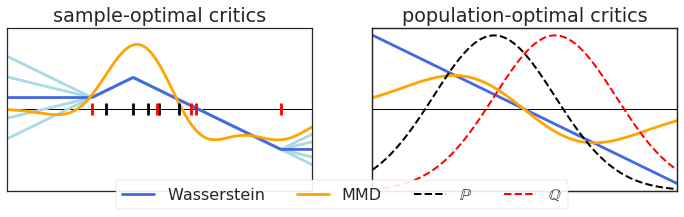

713679

In [22]:
# seed = np.random.randint(2**20)
seed = 713679
rs = np.random.RandomState(seed=seed)
ns = [5, 100_000]
Ps = []
Qs = []

mp = -.1
mq = -mp
sp = np.abs(mp - mq)
sq = sp
bw = np.abs(mp - mq) / 2

for n in ns:
    Ps.append(rs.normal(loc=mp, scale=sp, size=n))
    Qs.append(rs.normal(loc=mq, scale=sq, size=n))

r = 2
xx = np.linspace(min(mp - r * sp, mq - r * sq),
                 max(mp + r * sp, mq + r * sq), 100)

gamma = 1 / (2 * bw**2)
mmd_wits = [get_MMD_witness(P, Q, kernel=partial(rbf_kernel, gamma=gamma))(xx)
            for P, Q in zip(Ps, Qs)]

W_wit_spectra = np.array([
    get_W_witness_spectrum(Ps[0], Qs[0])(xx),
    ((-1 if mp < mq else 1) * xx,) * 2,
])
W_wit_spectra -= W_wit_spectra.mean(axis=(1, 2), keepdims=True)



fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 3))

axes[0].axhline(0, color='k', ls='-', lw=1, zorder=-99)
axes[1].axhline(0, color='k', ls='-', lw=1, zorder=-99)

axes[0].scatter(Ps[0], np.zeros(ns[0]), color='black', marker='|', zorder=50)#, label='$X \sim \mathbb{P}^n$')
axes[0].scatter(Qs[0], np.zeros(ns[0]), color='red'  , marker='|', zorder=50)#, label='$Y \sim \mathbb{Q}^n$')

a = axes[1].twinx()
a.plot(xx, norm.pdf(xx, loc=mp, scale=sp), color='black', label='$\mathbb{P}$', lw=2, ls='--')
a.plot(xx, norm.pdf(xx, loc=mq, scale=sq), color='red'  , label='$\mathbb{Q}$', lw=2, ls='--')
a.set_ylim(0, a.get_ylim()[1])
a.set_yticks([])

a, b = W_wit_spectra[0]
for j in range(5):
    r = j / 4.
    if not np.allclose(r, .5):
        axes[0].plot(xx, r * W_wit_spectra[0][0] + (1-r) * W_wit_spectra[0][1], color='lightblue')

axes[0].plot(xx, .5 * W_wit_spectra[0][0] + .5 * W_wit_spectra[0][1], color='royalblue', label='Wasserstein')
axes[0].plot(xx, mmd_wits[0], color='orange', label='MMD')

axes[1].plot(xx, .5 * W_wit_spectra[1][0] + .5 * W_wit_spectra[1][1], color='royalblue', label='Wasserstein')
axes[1].plot(xx, mmd_wits[1], color='orange', label='MMD')

plt.xlim(xx[0], xx[-1])
# plt.ylim(xx[0] * 2/3, xx[-1] * 2/3)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[0].set_title('sample-optimal critics')
axes[1].set_title('population-optimal critics')

plt.figlegend(loc='lower center', ncol=4, frameon=True, framealpha=.9)
plt.show()

fig.savefig('../figs/witness.pdf', bbox_inches='tight', pad_inches=0.01)
seed